In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

In [13]:
# Load the preprocessed data from the .npz file with allow_pickle=True
npz_file_path = '../data/news/tfidf_data.npz'
data = np.load(npz_file_path, allow_pickle=True)

tfidf_train_data = data['tfidf_train_data']
tfidf_train_indices = data['tfidf_train_indices']
tfidf_train_indptr = data['tfidf_train_indptr']
tfidf_train_shape = data['tfidf_train_shape']

tfidf_test_data = data['tfidf_test_data']
tfidf_test_indices = data['tfidf_test_indices']
tfidf_test_indptr = data['tfidf_test_indptr']
tfidf_test_shape = data['tfidf_test_shape']

article_ids_train = data['article_ids_train']
categories_train = data['categories_train']
article_ids_test = data['article_ids_test']

In [14]:
# Reconstruct the sparse matrices
tfidf_train = csr_matrix((tfidf_train_data, tfidf_train_indices, tfidf_train_indptr), shape=tfidf_train_shape)
tfidf_test = csr_matrix((tfidf_test_data, tfidf_test_indices, tfidf_test_indptr), shape=tfidf_test_shape)

# Convert categories to a DataFrame
categories_train_df = pd.DataFrame(categories_train, columns=['Category'])
categories_train_df['Category'] = categories_train_df['Category'].astype(str)

# Encode the categories for easier comparison later
label_encoder = LabelEncoder()
encoded_categories = label_encoder.fit_transform(categories_train_df['Category'])


In [15]:
# Apply NMF for matrix factorization
n_components = 20  # Initial number of components
nmf_model = NMF(n_components=n_components, init='random', random_state=42)
W_train = nmf_model.fit_transform(tfidf_train)
H = nmf_model.components_

In [16]:
# Determine the predominant topic in each document by finding the maximum weight
predicted_topics_train = W_train.argmax(axis=1)

# Evaluate the accuracy of the topics with the known categories
categories_train_df['predicted_topic'] = predicted_topics_train

# Group predicted topics and true categories to find the most frequent true category per topic
topic_category_mapping = categories_train_df.groupby('predicted_topic')['Category'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# Map the predicted topics to categories using the topic-category mapping
categories_train_df['predicted_category'] = categories_train_df['predicted_topic'].map(topic_category_mapping)

# Evaluate performance on the training set
train_accuracy = accuracy_score(categories_train_df['Category'], categories_train_df['predicted_category'])
print(f'Training Accuracy: {train_accuracy}')

Training Accuracy: 0.883423180592992


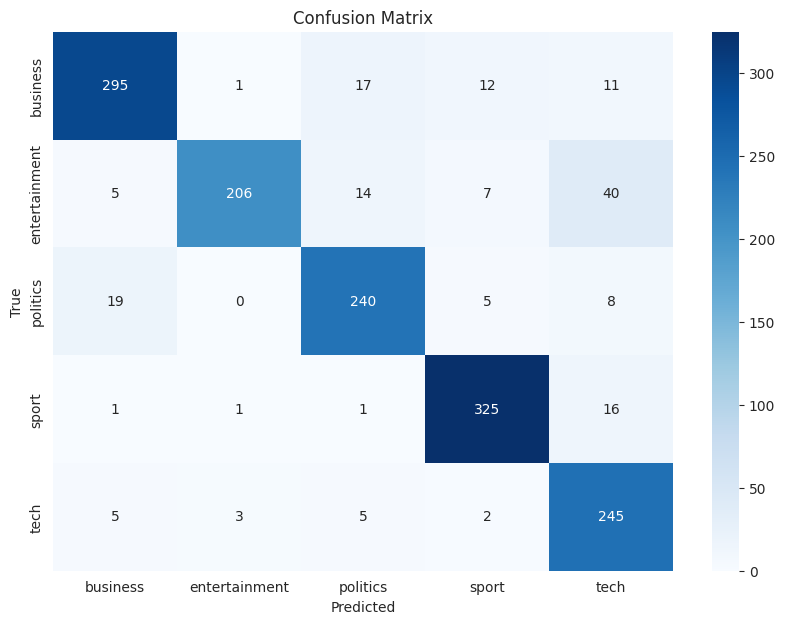

In [17]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for training data
plot_confusion_matrix(categories_train_df['Category'], categories_train_df['predicted_category'], classes=label_encoder.classes_)


In [18]:
# Predict topics for the test set
W_test = nmf_model.transform(tfidf_test)
predicted_topics_test = W_test.argmax(axis=1)


In [19]:
# Map the predicted topics to categories using the topic-category mapping
predicted_categories_test = pd.Series(predicted_topics_test).map(topic_category_mapping)


In [20]:
# Prepare submission file
submission = pd.DataFrame({
    'ArticleId': article_ids_test,  # Assuming the test data has an 'ArticleId' column
    'Category': predicted_categories_test
})
submission.to_csv('../data/news/unsupervised_news_classification_submission.csv', index=False)

In [21]:
# Hyperparameter tuning
results = []

for n_components in [5, 10, 20, 30, 40, 50]:
    nmf_model = NMF(n_components=n_components, init='random', random_state=42)
    W_train = nmf_model.fit_transform(tfidf_train)
    predicted_topics_train = W_train.argmax(axis=1)
    categories_train_df['predicted_topic'] = predicted_topics_train
    topic_category_mapping = categories_train_df.groupby('predicted_topic')['Category'].agg(lambda x: x.value_counts().idxmax()).to_dict()
    categories_train_df['predicted_category'] = categories_train_df['predicted_topic'].map(topic_category_mapping)
    train_accuracy = accuracy_score(categories_train_df['Category'], categories_train_df['predicted_category'])
    results.append((n_components, train_accuracy))

/home/panog/Matrix-Factorization-Project/venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/panog/Matrix-Factorization-Project/venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


   n_components  train_accuracy
0             5        0.905660
1            10        0.927898
2            20        0.883423
3            30        0.872642
4            40        0.877358
5            50        0.843666


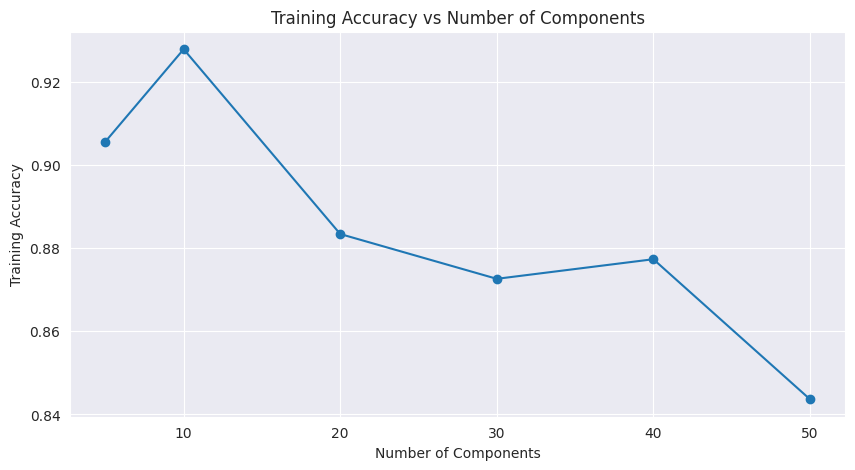

In [22]:
# Summarize results
results_df = pd.DataFrame(results, columns=['n_components', 'train_accuracy'])
print(results_df)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(results_df['n_components'], results_df['train_accuracy'], marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Number of Components')
plt.grid(True)
plt.show()